In [4]:
#standard imports 
import pandas as pd 
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import quandl
import functools
import os
import math
from datetime import datetime, timedelta
import requests

my_api_key = HIDDEN 
pd.set_option("max_columns", None) 
pd.set_option("max_rows", None)

## FINM Homework 3, By: Zachary Mariani
### Due: April 22, 2021 at 11:00 PM Chicago Time

# First Step: Define the Universe

In order to define the universe, we're going to take the following steps:
1. Get all of the possible tickers in the world
2. Filter by Zacks' Sector Code to get rid of auto, finance, and insurance companies 
3. Filter them by companies who have debt/market cap ratios of greater than 0.1 at some point over the window 
4. Check to see if Quandl has EOD prices for the security for the entire window

In [5]:
#get all of the tickers that we could possibly use and take a look at them
tickers = pd.read_csv('http://static.quandl.com/zacks/zacks-tickers.csv', header = None)
tickers.columns = ['ticker', 'full']
tickers.head()

,ticker,full
0,3262Q,CMS ENERGY -G
1,A,AGILENT TECH
2,AA,ALCOA INC
3,AAAP,ADV ACCELERATOR
4,AAC,AAC HOLDINGS


In [ ]:
%%time
#now that we have the full list of tickers, it is most computationally efficient to filter first by industry 
#we know that the sector x codes 13 correspond to Finance and Insurance while 5 is automotive, this takes a 
#very long time roughly 24 minutes to run, there are probably more efficient ways to do this and 
#I used the try/except and the loop to make sure that it works, I also broke it down into (0,890) and (0, 890 *2)
#just so that I could see what was going on half way through 

 
for i in range(890, 890*2):

    tickers_str = ''
    try: 
        
        for ticker in tickers.iloc[i*5:(i+1)*5]['ticker']:
            tickers_str = tickers_str + (ticker + ',')
            
        test = quandl.get_table('ZACKS/FC', ticker=tickers_str)
        test = test[['zacks_sector_code', 'ticker', 'per_end_date']]
        test.set_index(['ticker'], inplace=True)
        test = test[test.zacks_sector_code != 13]
        test = test[test.zacks_sector_code != 5]
        
            
        for ticker in tickers.iloc[i*5:(i+1)*5]['ticker']:
            if len(test.loc[ticker]['zacks_sector_code'].unique()) == 1:
                sector_code = test.loc[ticker]['zacks_sector_code'].unique()[0]
                full_dict[ticker] = sector_code
                
    except Exception as e: 
        #this print will let us know which securities aren't working, it'll say key error and then the security
        #i've removed the output because it's very long and not helpful to the reader 
        print(e)
        


In [ ]:
#we can now take a look and see how many we got after just filtering based on the sector 
len(full_dict)
#returns: 3508

Now that we have the filtering by the sectors, down to 3508 securities, we will go ahead and filter them by debt over market cap. I couldn't find this statistic within the the database, so I took just the ZACKS/FC total long term debt and put it over the ZACHS/MKTV market cap filter. This takes a very long time approximately 12 minutes 

I realized later that this was not exactly what was asked by the assignment. However, I think that my metric will work well and measures the same thing. Additionally, I already spent a great deal of computing time and power on this, so I decided to stick with my results here. Futher, this includes both long and short term debt which I don't think the other measurement does. 

In [186]:
%%time

mkt_value_dict = {}

#we break this down into 697 bites of 5 securities each, this helps with speed/accuracy, and getting cut out of 
#Quandl's data

for i in range (0, 697):
    try:
        
        
        list_to_use = list_to_play[i * 5 : (i+1) * 5]
        full_str = ''
        
        for sec, value in list_to_use: 
            full_str = full_str + str(sec) + ','
            
        #we order LTERM debt data from Quandl
        TOT_LTERM_DEBT = quandl.get_table('ZACKS/FC', ticker=full_str)
        
        #reduce it down to just what we need 
        TOT_LTERM_DEBT = TOT_LTERM_DEBT[['tot_lterm_debt', 'per_end_date', 'ticker']]
        
        TOT_LTERM_DEBT['tot_lterm_debt'] = TOT_LTERM_DEBT['tot_lterm_debt'] 
        TOT_LTERM_DEBT.set_index('per_end_date', inplace=True)
        TOT_LTERM_DEBT.sort_index(inplace=True);
        TOT_LTERM_DEBT = TOT_LTERM_DEBT.loc['2012-12-31' : '2020-03-31']
        TOT_LTERM_DEBT.reset_index(inplace=True)
        TOT_LTERM_DEBT.set_index(['ticker','per_end_date'], inplace=True)
        
        #now order the MKTV data from Quandl
        mkt_val = quandl.get_table("ZACKS/MKTV", ticker = full_str);
        mkt_val = mkt_val[['per_end_date', 'mkt_val', 'ticker']]
        mkt_val.set_index('per_end_date', inplace=True)
        mkt_val.sort_index(inplace=True);
        mkt_val = mkt_val.loc['2012-12-31' : '2020-03-31']
        mkt_val.reset_index(inplace=True)
        mkt_val.set_index(['ticker','per_end_date'], inplace=True)
        
        dbt_over_mkt_cap = pd.DataFrame()
        
        #generate our own ratio (oops should've just used TOT_DEBT_TOT_EQUITY) 
        dbt_over_mkt_cap['dbt_over_mkt_cap'] = TOT_LTERM_DEBT['tot_lterm_debt'] / mkt_val['mkt_val']
        dbt_over_mkt_cap.reset_index(inplace=True)
        dbt_over_mkt_cap.set_index('ticker', inplace=True)


        #now just verify that we have at least once where the ratio was above 0.1 as per 
        #assignment requirements
        for sec in dbt_over_mkt_cap.index.unique():
            if dbt_over_mkt_cap.loc[sec]['dbt_over_mkt_cap'].max() > 0.1:
                mkt_value_dict[sec] = True
        
        
    except Exception as e:
        print(e)




CPU times: user 5min 24s, sys: 4.85 s, total: 5min 29s
Wall time: 12min 28s


In [188]:
#now that we have the tickers filtered to sufficiently good debt/market cap ratios and the sector, see how many 
#we have left

len(mkt_value_dict)

1633

In [2]:
#at this point, let's save our work to a csv file just in case
#plus leaving everything in our memory makes the computer very slow 

mkt_value_list = list(mkt_value_dict.items())
mkt_value_list[0:10]
secs_to_use = [i[0] for i in mkt_value_list]
secs_to_use_dict = {}
secs_to_use_dict['sec'] = secs_to_use
secs_to_use_df = pd.DataFrame.from_dict(secs_to_use_dict)
secs_to_use_df.to_csv('/Users/zachmariani/Desktop/backup.csv')

In [33]:
#we can then reload all of the data into our computer to speed everything back up 
secs_to_use_df = pd.read_csv('/Users/zachmariani/Desktop/backup.csv')
secs_to_use = secs_to_use_df['sec']
secs_to_use;

Finally, we have filtered by industry/sector and by debt/market cap so our final task will be to filter by EOD prices, we will do this by pulling the data for each security from Quandl's EOD 

In [ ]:
%%time 
#take a look to see if end of day returns are avaiable 

final_list_of_secs = []

def verify_eod_returns(ticker):
    
    try:
        #first we pull the data set 
        eod = quandl.get('EOD/' + str(ticker), returns = 'pandas', 
                api_key = my_api_key, start_date = '2013-01-01', end_date = '2020-01-01')
    
        eod = eod['Adj_Close']
        
        #then check to see if it has the right start and end days, if so add the ticker to the final ticker list
        if (str(eod.index[0]) == '2013-01-02 00:00:00') and (str(eod.index[-1]) == '2019-12-31 00:00:00'):
            final_list_of_secs.append(ticker)
            print('Success')
        
        else:
            print('Fail')
            pass   
        
    except Exception as e: 
        pass 


for sec in secs_to_use:
    print(sec)
    verify_eod_returns(sec)


In [36]:
#again we back up all of our data! 
backup_2_dict = {}
backup_2_dict['sec'] = final_list_of_secs
backup_2_df = pd.DataFrame.from_dict(backup_2_dict)
backup_2_df.to_csv('/Users/zachmariani/Desktop/backup_final.csv')

Now that we have finished filtering, check to see how many securities there are. From here, we will continue onwards with getting the debt to market cap, return on investment, and price to earnings data.

In [44]:
len(final_list_of_secs)

843

# Step Two: Select Financial Ratios

In [398]:
#get the full list of all 843 securities we care about now 
sec_order = ''
for item in final_list_of_secs:
    sec_order = sec_order + str(item) + ','
sec_order;

#get only a certain number of days worth of data 
dates_to_order = ''
months_days = ['03-31', '06-30', '09-30', '12-31']
years = ['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
for year in years:
    for month_day in months_days:
        dates_to_order = dates_to_order + year + '-' + month_day + ','
dates_to_order;

In [399]:
#build a dictionary for columns which we care about 
cols_of_interest = {}
cols_of_interest['FR'] = ['ticker', 'per_end_date', 'per_type', 'tot_debt_tot_equity', 'ret_invst']
cols_of_interest['MKTV'] = ['ticker', 'per_end_date', 'per_type', 'mkt_val']
cols_of_interest['FC'] = ['ticker', 'per_end_date', 'per_type', 'net_lterm_debt', \
                          'tot_lterm_debt', 'eps_diluted_net', 'basic_net_eps']
cols_of_interest['SHRS'] = ['ticker', 'per_end_date', 'per_type', 'shares_out']


#set all of our dataframes to empty, we use an append strategy 
FR = pd.DataFrame()
MKTV = pd.DataFrame()
FC = pd.DataFrame()
SHRS = pd.DataFrame()


In [400]:
FR_df = quandl.get_table('ZACKS/FR', ticker=sec_order, per_end_date=dates_to_order, paginate=True)
FR_df = FR_df[cols_of_interest['FR']]

for item in final_list_of_secs:
    try:
        if FR_df[FR_df['ticker'] == item].loc[FR_df['per_type'] == 'Q'].empty: 
            FR = FR.append(FR_df[FR_df['ticker'] == item])
        else:
            FR = FR.append( FR_df[FR_df['ticker'] == item].loc[FR_df['per_type'] == 'Q'] )
    except: 
        print('Failed on:', item)

FR.set_index(['per_end_date', 'ticker'], inplace=True)

In [401]:
FR.tail(5)

,,per_type,tot_debt_tot_equity,ret_invst
per_end_date,ticker,,,
2019-12-31,YORW,Q,0.7530,1.4817
2020-03-31,YORW,Q,0.7439,1.7312
2020-06-30,YORW,Q,0.7438,1.7785
2020-09-30,YORW,Q,0.8261,1.8214
2020-12-31,YORW,Q,0.8626,1.3904


In [175]:
MKTV_df = quandl.get_table('ZACKS/MKTV', ticker='AAPL')
MKTV_df = MKTV_df[cols_of_interest['MKTV']];

for item in final_list_of_secs:
    try:
        if MKTV_df[MKTV_df['ticker'] == item].loc[MKTV_df['per_type'] == 'Q'].empty: 
            MKTV = MKTV.append(MKTV_df[MKTV_df['ticker'] == item])

        else:
            MKTV = MKTV.append( MKTV_df[MKTV_df['ticker'] == item][MKTV_df['per_type'] == 'Q'])
    except: 
        print('Failed on:', item)

In [176]:
FC_df = quandl.get_table('ZACKS/FC', ticker='AAPL')
FC_df = FC_df[cols_of_interest['FC']];

for item in final_list_of_secs:
    try:
        if FC_df[FC_df['ticker'] == item].loc[FC_df['per_type'] == 'Q'].empty: 
            FC = FC.append(FC_df[FC_df['ticker'] == item])

        else:
            FC = FC.append( FC_df[FC_df['ticker'] == item][FC_df['per_type'] == 'Q'])
    except: 
        print('Failed on:', item)

In [177]:
SHRS_df = quandl.get_table('ZACKS/SHRS', ticker='AAPL')
SHRS_df = SHRS_df[cols_of_interest['SHRS']]

for item in final_list_of_secs:
    try:
        if SHRS_df[SHRS_df['ticker'] == item].loc[SHRS_df['per_type'] == 'Q'].empty: 
            SHRS = SHRS.append(SHRS_df[SHRS_df['ticker'] == item])

        else:
            SHRS = SHRS.append( SHRS_df[SHRS_df['ticker'] == item][SHRS_df['per_type'] == 'Q'])
    except: 
        print('Failed on:', item)

# Step Three: Build Our Algorithm
Now that we have all of the data that we need to build our quantiles, we will get started! 

In [402]:
#first is debt to market cap, we use this code to get the debt to market cap rankings for each day 
FRprime = pd.DataFrame()

for date in FR.index.get_level_values(0).unique():

    df_for_this_q = FR.loc[date]
    df_for_this_q['per_end_date'] = date
    df_for_this_q.reset_index(inplace=True)
    df_for_this_q.set_index(['per_end_date', 'ticker'], inplace=True)

    df_for_this_q['tot_debt_tot_equity_rank'] = df_for_this_q['tot_debt_tot_equity'].rank(pct=True)
    
    FRprime = FRprime.append(df_for_this_q)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [404]:
#take a look to see that the tot_debt_tot_equity_rank looks in order
FRprime.tail(10)

per_type  tot_debt_tot_equity  ret_invst  \
per_end_date ticker                                            
2020-12-31   WYY           Q                  NaN    20.4287   
             X             Q               1.2599     0.5715   
             XEC           Q               1.2793     0.6979   
             XEL           Q               1.4168     0.8416   
             XPO           Q               2.3542     1.5576   
             XRAY          Q               0.4581     1.4191   
             XRX           Q               0.7649     0.7809   
             XYL           Q               1.0363     2.7106   
             YNDX          Q               0.2406     0.5764   
             YORW          Q               0.8626     1.3904   

                     tot_debt_tot_equity_rank  
per_end_date ticker                            
2020-12-31   WYY                          NaN  
             X                       0.726106  
             XEC                     0.733238  
             XEL                     0.771755  
             XPO                     0.891583  
             XRAY                    0.363053  
             XRX                     0.554922  
             XYL                     0.654779  
             YNDX                    0.218260  
             YORW                    0.593438

In [482]:
order_book = pd.DataFrame()

#for the economic intutition, we would want to sell companies that have a really high debt to equity ratio 
#and buy companies that have a really low debt to equity ratio, lower debt might imply healither balance sheets
#more space in the future to grow etc. 

for date in FRprime.index.get_level_values(0).unique():
#     print(date)
    secs_to_buy = (FRprime.loc[date].loc[FRprime.loc[date]['tot_debt_tot_equity_rank'] < 0.10])
    secs_to_sell = (FRprime.loc[date].loc[FRprime.loc[date]['tot_debt_tot_equity_rank'] > 0.90])
    secs_to_buy['position'] = 1 
    secs_to_buy['per_end_date'] = date
    secs_to_sell['position'] = -1
    secs_to_sell['per_end_date'] = date
    
    order_book = order_book.append(secs_to_buy)
    order_book = order_book.append(secs_to_sell)

order_book.reset_index(inplace=True)
order_book.set_index(['per_end_date', 'ticker'], inplace=True);

In [483]:
#now we take a look at our order book to make sure that it makes sense
len(order_book)

4841

In [484]:
#the next step is going to get asset prices, so let's get the full list of assets we ever trade here 
secs_ordered = order_book.index.get_level_values(1).unique()
len(secs_ordered)
prices_to_order = []

for sec in secs_ordered:
    prices_to_order.append('EOD/' + sec)
len(prices_to_order)

411

In [485]:
%%time
price_data = quandl.get(prices_to_order, start_date='2013-01-01', end_date='2020-01-31', column_index = 11)
price_data.head()

CPU times: user 1min 48s, sys: 1.06 s, total: 1min 49s
Wall time: 4min 27s


,EOD/AAL - Adj_Close,EOD/ADES - Adj_Close,EOD/AGEN - Adj_Close,EOD/ALSK - Adj_Close,EOD/AMCX - Adj_Close,EOD/AMRN - Adj_Close,EOD/AWX - Adj_Close,EOD/AXGN - Adj_Close,EOD/BCPC - Adj_Close,EOD/BELFA - Adj_Close,EOD/BELFB - Adj_Close,EOD/BLFS - Adj_Close,EOD/BTG - Adj_Close,EOD/BWXT - Adj_Close,EOD/CAJ - Adj_Close,EOD/CDZI - Adj_Close,EOD/CIDM - Adj_Close,EOD/CPHI - Adj_Close,EOD/CPIX - Adj_Close,EOD/CROX - Adj_Close,EOD/CSS - Adj_Close,EOD/EXAS - Adj_Close,EOD/FOLD - Adj_Close,EOD/FSM - Adj_Close,EOD/GNMK - Adj_Close,EOD/HTHT - Adj_Close,EOD/HUBG - Adj_Close,EOD/INCY - Adj_Close,EOD/IPAR - Adj_Close,EOD/ITRN - Adj_Close,EOD/KAI - Adj_Close,EOD/KBR - Adj_Close,EOD/KGJI - Adj_Close,EOD/KTCC - Adj_Close,EOD/LCI - Adj_Close,EOD/LEE - Adj_Close,EOD/MACK - Adj_Close,EOD/MAR - Adj_Close,EOD/MASI - Adj_Close,EOD/MDCA - Adj_Close,EOD/MEET - Adj_Close,EOD/MNKD - Adj_Close,EOD/NATR - Adj_Close,EOD/NCMI - Adj_Close,EOD/NEPT - Adj_Close,EOD/NKTR - Adj_Close,EOD/OGEN - Adj_Close,EOD/OII - Adj_Close,EOD/OMER - Adj_Close,EOD/OMEX - Adj_Close,EOD/ORN - Adj_Close,EOD/PAAS - Adj_Close,EOD/PAR - Adj_Close,EOD/PDEX - Adj_Close,EOD/PDLI - Adj_Close,EOD/PTN - Adj_Close,EOD/RIBT - Adj_Close,EOD/ROLL - Adj_Close,EOD/SBH - Adj_Close,EOD/SCSC - Adj_Close,EOD/SPHS - Adj_Close,EOD/SQNS - Adj_Close,EOD/SREV - Adj_Close,EOD/STXS - Adj_Close,EOD/SYNA - Adj_Close,EOD/TEO - Adj_Close,EOD/TRQ - Adj_Close,EOD/URG - Adj_Close,EOD/UUU - Adj_Close,EOD/VRSN - Adj_Close,EOD/VVI - Adj_Close,EOD/WERN - Adj_Close,EOD/ABG - Adj_Close,EOD/AES - Adj_Close,EOD/AL - Adj_Close,EOD/AMD - Adj_Close,EOD/AMKR - Adj_Close,EOD/APPS - Adj_Close,EOD/ASUR - Adj_Close,EOD/AXAS - Adj_Close,EOD/BC - Adj_Close,EOD/BKD - Adj_Close,EOD/BLDR - Adj_Close,EOD/BLMN - Adj_Close,EOD/CAPL - Adj_Close,EOD/CAR - Adj_Close,EOD/CAT - Adj_Close,EOD/CATM - Adj_Close,EOD/CCK - Adj_Close,EOD/CHEF - Adj_Close,EOD/CHTR - Adj_Close,EOD/CLX - Adj_Close,EOD/CMRE - Adj_Close,EOD/CMS - Adj_Close,EOD/CNP - Adj_Close,EOD/CQP - Adj_Close,EOD/CSIQ - Adj_Close,EOD/CSU - Adj_Close,EOD/DENN - Adj_Close,EOD/DIN - Adj_Close,EOD/DISH - Adj_Close,EOD/DNKN - Adj_Close,EOD/EGAN - Adj_Close,EOD/EVC - Adj_Close,EOD/FLY - Adj_Close,EOD/FRGI - Adj_Close,EOD/FRO - Adj_Close,EOD/GATX - Adj_Close,EOD/GE - Adj_Close,EOD/GMLP - Adj_Close,EOD/GOL - Adj_Close,EOD/GPK - Adj_Close,EOD/GSK - Adj_Close,EOD/GTN - Adj_Close,EOD/HBP - Adj_Close,EOD/HUN - Adj_Close,EOD/JKS - Adj_Close,EOD/KNX - Adj_Close,EOD/KTOS - Adj_Close,EOD/LBTYK - Adj_Close,EOD/LMT - Adj_Close,EOD/MARK - Adj_Close,EOD/MAS - Adj_Close,EOD/MO - Adj_Close,EOD/MTW - Adj_Close,EOD/NNA - Adj_Close,EOD/OI - Adj_Close,EOD/PKOH - Adj_Close,EOD/PNRG - Adj_Close,EOD/PTNR - Adj_Close,EOD/RDNT - Adj_Close,EOD/RRD - Adj_Close,EOD/S - Adj_Close,EOD/SEE - Adj_Close,EOD/SGMS - Adj_Close,EOD/SUN - Adj_Close,EOD/TEF - Adj_Close,EOD/TGH - Adj_Close,EOD/THC - Adj_Close,EOD/TMUS - Adj_Close,EOD/TNK - Adj_Close,EOD/TPX - Adj_Close,EOD/TRTN - Adj_Close,EOD/URI - Adj_Close,EOD/VRSK - Adj_Close,EOD/AEIS - Adj_Close,EOD/NETE - Adj_Close,EOD/OTEL - Adj_Close,EOD/PRGX - Adj_Close,EOD/AMRS - Adj_Close,EOD/BAK - Adj_Close,EOD/BGS - Adj_Close,EOD/CEA - Adj_Close,EOD/CHNR - Adj_Close,EOD/CSOD - Adj_Close,EOD/GNRC - Adj_Close,EOD/GTT - Adj_Close,EOD/LNG - Adj_Close,EOD/RXN - Adj_Close,EOD/AIRT - Adj_Close,EOD/ASM - Adj_Close,EOD/BEAT - Adj_Close,EOD/JOUT - Adj_Close,EOD/PLX - Adj_Close,EOD/PWR - Adj_Close,EOD/SYNC - Adj_Close,EOD/WTT - Adj_Close,EOD/DKL - Adj_Close,EOD/EXEL - Adj_Close,EOD/RADA - Adj_Close,EOD/TK - Adj_Close,EOD/X - Adj_Close,EOD/AIT - Adj_Close,EOD/ALIM - Adj_Close,EOD/BDSI - Adj_Close,EOD/FLWS - Adj_Close,EOD/GIL - Adj_Close,EOD/LFVN - Adj_Close,EOD/MD - Adj_Close,EOD/PENN - Adj_Close,EOD/PLUG - Adj_Close,EOD/SRT - Adj_Close,EOD/UFPT - Adj_Close,EOD/UUUU - Adj_Close,EOD/GSS - Adj_Close,EOD/MX - Adj_Close,EOD/PCRX - Adj_Close,EOD/REED - Adj_Close,EOD/TAST - Adj_Close,EOD/AG - Adj_Close,EOD/AXDX - Adj_Close,EOD/BIIB - Adj_Close,EOD/BRKS - Adj_Close,EOD/CAKE - Adj_Close,EOD/DLHC - Adj_Clos

In [486]:
#again we want to back up the data once we get it so: 
price_data.to_csv('/Users/zachmariani/Desktop/price_data_backup.csv')

In [487]:
#get all of the pct_changes for the dataframe
pct_change_df = price_data.pct_change(1)

In [488]:
#take a look at them! 
pct_change_df.head()

,EOD/AAL - Adj_Close,EOD/ADES - Adj_Close,EOD/AGEN - Adj_Close,EOD/ALSK - Adj_Close,EOD/AMCX - Adj_Close,EOD/AMRN - Adj_Close,EOD/AWX - Adj_Close,EOD/AXGN - Adj_Close,EOD/BCPC - Adj_Close,EOD/BELFA - Adj_Close,EOD/BELFB - Adj_Close,EOD/BLFS - Adj_Close,EOD/BTG - Adj_Close,EOD/BWXT - Adj_Close,EOD/CAJ - Adj_Close,EOD/CDZI - Adj_Close,EOD/CIDM - Adj_Close,EOD/CPHI - Adj_Close,EOD/CPIX - Adj_Close,EOD/CROX - Adj_Close,EOD/CSS - Adj_Close,EOD/EXAS - Adj_Close,EOD/FOLD - Adj_Close,EOD/FSM - Adj_Close,EOD/GNMK - Adj_Close,EOD/HTHT - Adj_Close,EOD/HUBG - Adj_Close,EOD/INCY - Adj_Close,EOD/IPAR - Adj_Close,EOD/ITRN - Adj_Close,EOD/KAI - Adj_Close,EOD/KBR - Adj_Close,EOD/KGJI - Adj_Close,EOD/KTCC - Adj_Close,EOD/LCI - Adj_Close,EOD/LEE - Adj_Close,EOD/MACK - Adj_Close,EOD/MAR - Adj_Close,EOD/MASI - Adj_Close,EOD/MDCA - Adj_Close,EOD/MEET - Adj_Close,EOD/MNKD - Adj_Close,EOD/NATR - Adj_Close,EOD/NCMI - Adj_Close,EOD/NEPT - Adj_Close,EOD/NKTR - Adj_Close,EOD/OGEN - Adj_Close,EOD/OII - Adj_Close,EOD/OMER - Adj_Close,EOD/OMEX - Adj_Close,EOD/ORN - Adj_Close,EOD/PAAS - Adj_Close,EOD/PAR - Adj_Close,EOD/PDEX - Adj_Close,EOD/PDLI - Adj_Close,EOD/PTN - Adj_Close,EOD/RIBT - Adj_Close,EOD/ROLL - Adj_Close,EOD/SBH - Adj_Close,EOD/SCSC - Adj_Close,EOD/SPHS - Adj_Close,EOD/SQNS - Adj_Close,EOD/SREV - Adj_Close,EOD/STXS - Adj_Close,EOD/SYNA - Adj_Close,EOD/TEO - Adj_Close,EOD/TRQ - Adj_Close,EOD/URG - Adj_Close,EOD/UUU - Adj_Close,EOD/VRSN - Adj_Close,EOD/VVI - Adj_Close,EOD/WERN - Adj_Close,EOD/ABG - Adj_Close,EOD/AES - Adj_Close,EOD/AL - Adj_Close,EOD/AMD - Adj_Close,EOD/AMKR - Adj_Close,EOD/APPS - Adj_Close,EOD/ASUR - Adj_Close,EOD/AXAS - Adj_Close,EOD/BC - Adj_Close,EOD/BKD - Adj_Close,EOD/BLDR - Adj_Close,EOD/BLMN - Adj_Close,EOD/CAPL - Adj_Close,EOD/CAR - Adj_Close,EOD/CAT - Adj_Close,EOD/CATM - Adj_Close,EOD/CCK - Adj_Close,EOD/CHEF - Adj_Close,EOD/CHTR - Adj_Close,EOD/CLX - Adj_Close,EOD/CMRE - Adj_Close,EOD/CMS - Adj_Close,EOD/CNP - Adj_Close,EOD/CQP - Adj_Close,EOD/CSIQ - Adj_Close,EOD/CSU - Adj_Close,EOD/DENN - Adj_Close,EOD/DIN - Adj_Close,EOD/DISH - Adj_Close,EOD/DNKN - Adj_Close,EOD/EGAN - Adj_Close,EOD/EVC - Adj_Close,EOD/FLY - Adj_Close,EOD/FRGI - Adj_Close,EOD/FRO - Adj_Close,EOD/GATX - Adj_Close,EOD/GE - Adj_Close,EOD/GMLP - Adj_Close,EOD/GOL - Adj_Close,EOD/GPK - Adj_Close,EOD/GSK - Adj_Close,EOD/GTN - Adj_Close,EOD/HBP - Adj_Close,EOD/HUN - Adj_Close,EOD/JKS - Adj_Close,EOD/KNX - Adj_Close,EOD/KTOS - Adj_Close,EOD/LBTYK - Adj_Close,EOD/LMT - Adj_Close,EOD/MARK - Adj_Close,EOD/MAS - Adj_Close,EOD/MO - Adj_Close,EOD/MTW - Adj_Close,EOD/NNA - Adj_Close,EOD/OI - Adj_Close,EOD/PKOH - Adj_Close,EOD/PNRG - Adj_Close,EOD/PTNR - Adj_Close,EOD/RDNT - Adj_Close,EOD/RRD - Adj_Close,EOD/S - Adj_Close,EOD/SEE - Adj_Close,EOD/SGMS - Adj_Close,EOD/SUN - Adj_Close,EOD/TEF - Adj_Close,EOD/TGH - Adj_Close,EOD/THC - Adj_Close,EOD/TMUS - Adj_Close,EOD/TNK - Adj_Close,EOD/TPX - Adj_Close,EOD/TRTN - Adj_Close,EOD/URI - Adj_Close,EOD/VRSK - Adj_Close,EOD/AEIS - Adj_Close,EOD/NETE - Adj_Close,EOD/OTEL - Adj_Close,EOD/PRGX - Adj_Close,EOD/AMRS - Adj_Close,EOD/BAK - Adj_Close,EOD/BGS - Adj_Close,EOD/CEA - Adj_Close,EOD/CHNR - Adj_Close,EOD/CSOD - Adj_Close,EOD/GNRC - Adj_Close,EOD/GTT - Adj_Close,EOD/LNG - Adj_Close,EOD/RXN - Adj_Close,EOD/AIRT - Adj_Close,EOD/ASM - Adj_Close,EOD/BEAT - Adj_Close,EOD/JOUT - Adj_Close,EOD/PLX - Adj_Close,EOD/PWR - Adj_Close,EOD/SYNC - Adj_Close,EOD/WTT - Adj_Close,EOD/DKL - Adj_Close,EOD/EXEL - Adj_Close,EOD/RADA - Adj_Close,EOD/TK - Adj_Close,EOD/X - Adj_Close,EOD/AIT - Adj_Close,EOD/ALIM - Adj_Close,EOD/BDSI - Adj_Close,EOD/FLWS - Adj_Close,EOD/GIL - Adj_Close,EOD/LFVN - Adj_Close,EOD/MD - Adj_Close,EOD/PENN - Adj_Close,EOD/PLUG - Adj_Close,EOD/SRT - Adj_Close,EOD/UFPT - Adj_Close,EOD/UUUU - Adj_Close,EOD/GSS - Adj_Close,EOD/MX - Adj_Close,EOD/PCRX - Adj_Close,EOD/REED - Adj_Close,EOD/TAST - Adj_Close,EOD/AG - Adj_Close,EOD/AXDX - Adj_Close,EOD/BIIB - Adj_Close,EOD/BRKS - Adj_Close,EOD/CAKE - Adj_Close,EOD/DLHC - Adj_Clos

In [489]:
#take a look at our order book in its current form 
order_book.head(10)

per_type  tot_debt_tot_equity  ret_invst  \
per_end_date ticker                                            
2013-03-31   AAL           Q              -0.9918    25.1661   
             ADES          Q              -0.0685     0.9488   
             AGEN          Q              -1.6015   -43.4031   
             ALSK          Q             -18.0459     0.6924   
             AMCX          Q              -2.6286     4.5826   
             AMRN          Q              -3.9811   -34.7015   
             AWX           Q               0.0124    -0.3584   
             AXGN          Q              -3.7364   -20.9183   
             BCPC          Q               0.0115     3.7367   
             BELFA         Q               0.0006    -0.2660   

                     tot_debt_tot_equity_rank  position  
per_end_date ticker                                      
2013-03-31   AAL                     0.033058         1  
             ADES                    0.035813         1  
             AGEN                    0.027548         1  
             ALSK                    0.004132         1  
             AMCX                    0.019284         1  
             AMRN                    0.012397         1  
             AWX                     0.064738         1  
             AXGN                    0.013774         1  
             BCPC                    0.063361         1  
             BELFA                   0.039256         1

In [570]:
#the code below helps clean the data and prepare it for analysis

position_tracker1 = pd.DataFrame(position_tracker)
position_tracker1.reset_index(inplace=True)
# position_tracker1.set_index('ticker', inplace=True)
# position_tracker1 = position_tracker1.transpose()
new_position_tracker = position_tracker1.pivot('ticker', 'per_end_date').transpose().fillna(0).\
    reset_index().drop('level_0', axis =1).set_index('per_end_date')

#we do this replacement to simulate the costs that it would cost to short a position this rate is roughly a
#6% annual rate to borrow which makes sense 
new_position_tracker = new_position_tracker.replace(-1.0, -1.00023 )

In [571]:
#now take a look
new_position_tracker.tail()

ticker,AAL,ABC,ABG,ACH,ADES,ADUS,AEIS,AES,AG,AGEN,AGI,AIRI,AIRT,AIT,AL,ALGT,ALIM,ALSK,AMCX,AMD,AMED,AMKR,AMRN,AMRS,AMX,APA,APDN,APPS,ARAY,ARCO,ASM,ASTC,ASUR,ASYS,AT,ATEC,ATSG,AVEO,AWI,AWX,AXAS,AXDX,AXGN,BA,BAK,BC,BCEI,BCPC,BDSI,BEAT,BELFA,BELFB,BGFV,BGS,BIIB,BIO,BKD,BKR,BLDP,BLDR,BLFS,BLMN,BRFS,BRKS,BTG,BTN,BUD,BWXT,CAH,CAJ,CAKE,CAPL,CAR,CARB,CAT,CATM,CCK,CCLP,CDZI,CEA,CEMI,CHCI,CHEF,CHNR,CHTR,CIDM,CLF,CLVS,CLX,CMP,CMPR,CMRE,CMS,CNP,CNR,CPE,CPHI,CPIX,CQP,CRESY,CROX,CRUS,CRWS,CSIQ,CSOD,CSS,CSU,CTG,CTIC,CTXS,CWST,CYTK,DENN,DGLY,DHX,DIN,DISCA,DISCB,DISCK,DISH,DKL,DLHC,DNKN,DRD,DRRX,DSS,DVD,DWSN,DZSI,EGAN,EGY,ELMD,ELTK,ELY,ENPH,ENSV,ESTE,EVC,EXAS,EXEL,EXTR,FCX,FLWS,FLY,FOLD,FONR,FORTY,FRGI,FRO,FSM,FVE,GATX,GE,GEL,GEVO,GIL,GILT,GLBS,GLOG,GLUU,GMLP,GNC,GNMK,GNRC,GOL,GPK,GPRK,GRPN,GSB,GSK,GSL,GSS,GTE,GTN,GTS,GTT,GVP,HBP,HCKT,HDSN,HEP,HSKA,HTHT,HUBG,HUN,HY,IBIO,IBM,ICPT,IDXX,IESC,IGC,IGT,IIN,IMGN,INCY,INO,INSM,INUV,INVE,IO,IP,IPAR,IT,ITRN,JAKK,JBT,JHX,JKS,JOB,JOUT,KAI,KBR,KEM,KGJI,KMB,KNDI,KNX,KO,KOP,KRA,KTCC,KTOS,KVHI,KWR,LBTYK,LCI,LEE,LFVN,LGND,LHCG,LII,LIVE,LMT,LNG,LUNA,LVS,MACK,MANT,MAR,MARA,MARK,MAS,MASI,MAT,MBT,MCD,MD,MDCA,MDCO,MEET,MNKD,MO,MORN,MTW,MX,MXC,MYGN,NATR,NCMI,NEPT,NETE,NKTR,NM,NNA,NOG,NSSC,NUVA,NVFY,NWPX,OESX,OGEN,OI,OII,OIS,OKE,OLN,OMER,OMEX,ORN,OSIS,OSTK,OTEL,PAAS,PAC,PAM,PAR,PARR,PBH,PBYI,PCRX,PDEX,PDLI,PENN,PFIN,PFPT,PHX,PKOH,PLUG,PLX,PNRG,PODD,POOL,POST,PRGX,PRO,PRTK,PTN,PTNR,PWR,QCOM,QRHC,QUAD,QUMU,RADA,RAVE,RCKY,RDI,RDNT,REED,REGI,REI,RELV,RGLD,RGLS,RGS,RIBT,RNET,ROCK,ROG,ROLL,RRD,RRTS,RUTH,RXN,S,SAND,SBH,SCOR,SCSC,SEB,SEE,SGMS,SHEN,SHW,SIGA,SINA,SJI,SLAB,SMTX,SPHS,SPLP,SPPI,SPR,SQNS,SREV,SRNE,SRT,SSP,SSY,ST,STRL,STX,STXS,SUN,SWIR,SWN,SYNA,SYNC,SYY,TAST,TAT,TEF,TEO,TGH,TGI,TGNA,TGS,THC,TILE,TK,TLGT,TMUS,TNK,TPX,TREC,TRIP,TRQ,TRTN,TTI,TTWO,TWIN,UFPT,URG,URI,USAK,USPH,UUU,UUUU,VGZ,VIV,VRSK,VRSN,VVI,VZ,WEN,WERN,WES,WTT,WYY,X
per_end_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-31,1.0,0.0,-1.00023,0.0,0.0,0.0,0.0,-1.00023,0.0,1.0,0.0,-1.00023,-1.00023,0.0,-1.00023,0.00000,1.0,0.0,-1.00023,0.0,0.0,0.0,0.0,1.0,-1.00023,0.0,0.0,0.0,-1.00023,0.00000,0.0,-1.00023,0.0,1.0,-1.00023,0.00000,-1.00023,0.0,0.0,0.0,0.00000,1.0,1.0,1.0,-1.00023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,-1.00023,0.0,0.0,0.0,0.0,-1.00023,0.00000,1.0,0.0,0.0,0.0,0.0,-1.00023,0.0,0.0,-1.00023,-1.00023,0.0,-1.00023,0.00000,-1.00023,-1.00023,1.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,-1.00023,1.0,-1.00023,-1.00023,1.0,0.0,-1.00023,0.0,-1.00023,0.00000,0.0,0.0,-1.00023,-1.00023,0.00000,0.0,0.0,0.0,0.00000,0.0,-1.00023,0.0,0.0,0.00000,-1.00023,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.00000,0.0,0.0,0.0,0.0,-1.00023,0.0,0.0,-1.00023,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.00023,-1.00023,0.00000,0.0,0.0,1.0,0.00000,0.00000,0.0,0.0,1.0,-1.00023,0.0,1.0,0.0,-1.00023,0.00000,1.0,0.0,0.0,1.00000,0.00000,0.0,0.0,-1.00023,0.0,-1.00023,0.0,0.00000,-1.00023,0.0,0.00000,0.0,0.0,0.0,1.00000,-1.00023,-1.00023,-1.00023,1.0,1.0,-1.00023,1.0,1.0,1.0,-1.00023,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.00023,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,-1.00023,0.0,0.0,0.00000,-1.00023,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,1.0,0.0,0.0,1.0,0.0,-1.00023,-1.00023,1.0,0.00000,0.0,1.0,-1.00023,0.0,1.0,1.00000,0.0,-1.00023,-1.00023,1.0,0.0,1.0,0.0,0.0,1.0,-1.00023,0.0,0.0,1.00000,1.0,0.0,1.0,1.0,1.0,0.00000,0.0,-1.00023,-1.00023,0.00000,0.0,0.0,0.0,0.0,1.0,1.0,-1.00023,0.0,0.0,0.00000,0.00000,1.0,1.0,0.0,0.0,0.0,-1.00023,0.0,0.0,0.0,0.0,0.00000,0.0,-1.00023,0.0,0.0,1.0,-1.00023,0.0,0.0,0.0,0.0,-1.00023,1.0,0.0,-1.00023,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.00023,0.0,-1.00023,

In [572]:
#clean up the column names from the Quandl imports
remapping = {}
for col in price_data.columns:
    remapping[col] = col.replace('EOD/', '').replace(' - Adj_Close', '')
price_data.rename(columns = remapping, 
                 inplace=True)

In [573]:
pct_change_df = price_data.pct_change(1)
remapping = {}
for col in pct_change_df.columns:
    remapping[col] = col.replace('EOD/', '').replace(' - Adj_Close', '')
pct_change_df.rename(columns = remapping, 
                 inplace=True)

In [574]:
#take a look 
price_data.head()

,AAL,ADES,AGEN,ALSK,AMCX,AMRN,AWX,AXGN,BCPC,BELFA,BELFB,BLFS,BTG,BWXT,CAJ,CDZI,CIDM,CPHI,CPIX,CROX,CSS,EXAS,FOLD,FSM,GNMK,HTHT,HUBG,INCY,IPAR,ITRN,KAI,KBR,KGJI,KTCC,LCI,LEE,MACK,MAR,MASI,MDCA,MEET,MNKD,NATR,NCMI,NEPT,NKTR,OGEN,OII,OMER,OMEX,ORN,PAAS,PAR,PDEX,PDLI,PTN,RIBT,ROLL,SBH,SCSC,SPHS,SQNS,SREV,STXS,SYNA,TEO,TRQ,URG,UUU,VRSN,VVI,WERN,ABG,AES,AL,AMD,AMKR,APPS,ASUR,AXAS,BC,BKD,BLDR,BLMN,CAPL,CAR,CAT,CATM,CCK,CHEF,CHTR,CLX,CMRE,CMS,CNP,CQP,CSIQ,CSU,DENN,DIN,DISH,DNKN,EGAN,EVC,FLY,FRGI,FRO,GATX,GE,GMLP,GOL,GPK,GSK,GTN,HBP,HUN,JKS,KNX,KTOS,LBTYK,LMT,MARK,MAS,MO,MTW,NNA,OI,PKOH,PNRG,PTNR,RDNT,RRD,S,SEE,SGMS,SUN,TEF,TGH,THC,TMUS,TNK,TPX,TRTN,URI,VRSK,AEIS,NETE,OTEL,PRGX,AMRS,BAK,BGS,CEA,CHNR,CSOD,GNRC,GTT,LNG,RXN,AIRT,ASM,BEAT,JOUT,PLX,PWR,SYNC,WTT,DKL,EXEL,RADA,TK,X,AIT,ALIM,BDSI,FLWS,GIL,LFVN,MD,PENN,PLUG,SRT,UFPT,UUUU,GSS,MX,PCRX,REED,TAST,AG,AXDX,BIIB,BRKS,CAKE,DLHC,HSKA,JHX,KWR,LIVE,PHX,REGI,SEB,IBM,OKE,VZ,HDSN,MANT,OSIS,RAVE,SAND,AMX,CHCI,CMPR,JAKK,JOB,PFPT,PODD,ADUS,APDN,CLF,DRD,EGY,HY,LUNA,MORN,QRHC,SIGA,TREC,ARAY,AT,IDXX,IT,KOP,LGND,PBH,ASYS,DWSN,ESTE,FORTY,GLUU,GVP,PAC,SWIR,CRESY,KMB,LII,ST,TLGT,CWST,OESX,QCOM,REI,RUTH,ACH,IO,KEM,SHW,CTIC,DVD,INSM,NWPX,OSTK,QUMU,WYY,ABC,HEP,IGT,NOG,ATEC,DGLY,ELY,GTS,SCOR,SRNE,ARCO,GNC,MCD,QUAD,WEN,BLDP,CTG,ELMD,BCEI,GLBS,IP,DZSI,OIS,PFIN,TRIP,APA,CCLP,DSS,FCX,KRA,PRO,STX,SWN,TGS,FONR,IMGN,TWIN,AWI,BA,BUD,SHEN,NSSC,SLAB,AVEO,CLVS,ENPH,BKR,MARA,STRL,GPRK,INVE,JBT,SYY,USAK,CRUS,RCKY,SINA,CARB,DRRX,RRTS,AGI,NVFY,IBIO,MDCO,TGNA,BTN,CEMI,TTWO,DISCA,DISCB,DISCK,ENSV,ICPT,POOL,POST,FVE,MYGN,ELTK,KO,MAT,NM,GILT,CTXS,TGI,TTI,MXC,NUVA,PAM,PBYI,PRTK,IIN,CMP,MBT,RGLS,SJI,TAT,AMED,CRWS,HCKT,IGC,VIV,ATSG,BRFS,CNR,GSL,SMTX,IESC,RELV,ROCK,VGZ,CYTK,DHX,KVHI,SPPI,RGLD,CAH,EXTR,RNET,GSB,INUV,SSY,AIRI,ASTC,INO,TILE,WES,LHCG,GRPN,LVS,RGS,SPLP,BGFV,USPH,CPE,GTE,OLN,RDI,SPR,BIO,GEVO,KNDI,ROG,ALGT,GEL,GLOG,PARR,SSP
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-02,13.177430,6.741241,4.24,1.842714,51.00,8.1000,3.82,2.75,35.985335,15.372963,17.582490,4.76,3.657648,17.895905,29.531849,8.32,13.5,0.2600,4.28,14.80,18.722052,11.0500,2.84,4.36,9.4800,4.029371,34.35,17.0000,17.217333,10.315349,24.874759,26.756884,6.594532,10.63,5.09,11.8,30.063707,35.126027,21.33,6.722764,3.52,11.95,10.445281,7.734716,1.91,7.54,27.0,50.543897,5.39,35.520014,7.45,16.568704,4.915379,2.0500,5.515911,0.617,10.0,49.553496,24.73,33.0300,11.96,10.16,5.9900,3.2700,30.43,4.110782,87.29995,0.8670,4.35,39.85,22.044715,18.580290,32.26,8.523666,20.333786,2.53,4.421033,3.945,5.8800,45.8,28.256032,25.24,5.79,14.953300,8.893380,20.77,73.687475,23.99,37.852765,15.48,78.10,59.042744,8.092601,19.197426,14.171559,13.060293,3.40,286.049857,4.97,48.192881,36.96,28.489507,4.45,1.292134,10.667523,16.40,11.803909,35.411924,16.818676,13.185076,12.84,5.793350,28.352515,2.281167,1.77,13.024563,6.51,14.575185,4.9900,30.435,73.224096,1.9900,13.627652,21.067003,15.454865,15.312908,21.384403,19.499975,23.48,6.15,2.51,17.916449,5.79,15.827339,9.24,12.211777,8.577319,26.314491,33.39,13.017384,18.692985,8.155787,25.587208,47.91,52.187507,14.286832,336.0,1.55,6.4100,47.999976,9.497394,18.230366,19.456139,4.34,30.32,30.953920,2.85,19.50,21.460732,3.656385,1.9300,2.19,19.792872,54.0,27.640766,5.71,1.23,11.857284,4.83,2.10,27.578535,24.058977,36.605700,24.449988,4.51,3.78,16.683038,15.820016,42.045,11.643164,0.5000,4.07,18.95,8.650,9.50,15.80,17.38,5.90,6.27,21.16,4.3300,138.260733,7.156741,28.563563,0.77,8.2800,7.379009,51.383600,7.859984,14.005747,6.39,2619.286056,144.583323,23.992369,30.294079,3.75,22.623144,65.18,3.44,12.37,19.444905,8.050008,34.39,128.659724,5.5,12.97,21.49,7.3300,552.1104,34.5350

In [575]:
#make a copy to make it easier to manipulate and go back to fix errors later
price_data_to_play = pd.DataFrame()
price_data_to_play['empty'] = price_data['AAL']
price_data_to_play['empty'] = None

In [576]:
#set the quantile trackers to forwardfill over every avaiable trading day 
daily_position_tracker = new_position_tracker.append(price_data_to_play)\
.sort_index().drop('empty', axis=1).fillna(method='ffill')

In [577]:
#take a look 
daily_position_tracker.tail(10)

,AAL,ABC,ABG,ACH,ADES,ADUS,AEIS,AES,AG,AGEN,AGI,AIRI,AIRT,AIT,AL,ALGT,ALIM,ALSK,AMCX,AMD,AMED,AMKR,AMRN,AMRS,AMX,APA,APDN,APPS,ARAY,ARCO,ASM,ASTC,ASUR,ASYS,AT,ATEC,ATSG,AVEO,AWI,AWX,AXAS,AXDX,AXGN,BA,BAK,BC,BCEI,BCPC,BDSI,BEAT,BELFA,BELFB,BGFV,BGS,BIIB,BIO,BKD,BKR,BLDP,BLDR,BLFS,BLMN,BRFS,BRKS,BTG,BTN,BUD,BWXT,CAH,CAJ,CAKE,CAPL,CAR,CARB,CAT,CATM,CCK,CCLP,CDZI,CEA,CEMI,CHCI,CHEF,CHNR,CHTR,CIDM,CLF,CLVS,CLX,CMP,CMPR,CMRE,CMS,CNP,CNR,CPE,CPHI,CPIX,CQP,CRESY,CROX,CRUS,CRWS,CSIQ,CSOD,CSS,CSU,CTG,CTIC,CTXS,CWST,CYTK,DENN,DGLY,DHX,DIN,DISCA,DISCB,DISCK,DISH,DKL,DLHC,DNKN,DRD,DRRX,DSS,DVD,DWSN,DZSI,EGAN,EGY,ELMD,ELTK,ELY,ENPH,ENSV,ESTE,EVC,EXAS,EXEL,EXTR,FCX,FLWS,FLY,FOLD,FONR,FORTY,FRGI,FRO,FSM,FVE,GATX,GE,GEL,GEVO,GIL,GILT,GLBS,GLOG,GLUU,GMLP,GNC,GNMK,GNRC,GOL,GPK,GPRK,GRPN,GSB,GSK,GSL,GSS,GTE,GTN,GTS,GTT,GVP,HBP,HCKT,HDSN,HEP,HSKA,HTHT,HUBG,HUN,HY,IBIO,IBM,ICPT,IDXX,IESC,IGC,IGT,IIN,IMGN,INCY,INO,INSM,INUV,INVE,IO,IP,IPAR,IT,ITRN,JAKK,JBT,JHX,JKS,JOB,JOUT,KAI,KBR,KEM,KGJI,KMB,KNDI,KNX,KO,KOP,KRA,KTCC,KTOS,KVHI,KWR,LBTYK,LCI,LEE,LFVN,LGND,LHCG,LII,LIVE,LMT,LNG,LUNA,LVS,MACK,MANT,MAR,MARA,MARK,MAS,MASI,MAT,MBT,MCD,MD,MDCA,MDCO,MEET,MNKD,MO,MORN,MTW,MX,MXC,MYGN,NATR,NCMI,NEPT,NETE,NKTR,NM,NNA,NOG,NSSC,NUVA,NVFY,NWPX,OESX,OGEN,OI,OII,OIS,OKE,OLN,OMER,OMEX,ORN,OSIS,OSTK,OTEL,PAAS,PAC,PAM,PAR,PARR,PBH,PBYI,PCRX,PDEX,PDLI,PENN,PFIN,PFPT,PHX,PKOH,PLUG,PLX,PNRG,PODD,POOL,POST,PRGX,PRO,PRTK,PTN,PTNR,PWR,QCOM,QRHC,QUAD,QUMU,RADA,RAVE,RCKY,RDI,RDNT,REED,REGI,REI,RELV,RGLD,RGLS,RGS,RIBT,RNET,ROCK,ROG,ROLL,RRD,RRTS,RUTH,RXN,S,SAND,SBH,SCOR,SCSC,SEB,SEE,SGMS,SHEN,SHW,SIGA,SINA,SJI,SLAB,SMTX,SPHS,SPLP,SPPI,SPR,SQNS,SREV,SRNE,SRT,SSP,SSY,ST,STRL,STX,STXS,SUN,SWIR,SWN,SYNA,SYNC,SYY,TAST,TAT,TEF,TEO,TGH,TGI,TGNA,TGS,THC,TILE,TK,TLGT,TMUS,TNK,TPX,TREC,TRIP,TRQ,TRTN,TTI,TTWO,TWIN,UFPT,URG,URI,USAK,USPH,UUU,UUUU,VGZ,VIV,VRSK,VRSN,VVI,VZ,WEN,WERN,WES,WTT,WYY,X
2020-01-24,1.0,0.0,-1.00023,0.0,0.0,0.0,0.0,-1.00023,0.0,1.0,0.0,-1.00023,-1.00023,0.0,-1.00023,0.00000,1.0,0.0,-1.00023,0.0,0.0,0.0,0.0,1.0,-1.00023,0.0,0.0,0.0,-1.00023,0.00000,0.0,-1.00023,0.0,1.0,-1.00023,0.00000,-1.00023,0.0,0.0,0.0,0.00000,1.0,1.0,1.0,-1.00023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,-1.00023,0.0,0.0,0.0,0.0,-1.00023,0.00000,1.0,0.0,0.0,0.0,0.0,-1.00023,0.0,0.0,-1.00023,-1.00023,0.0,-1.00023,0.00000,-1.00023,-1.00023,1.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,-1.00023,1.0,-1.00023,-1.00023,1.0,0.0,-1.00023,0.0,-1.00023,0.00000,0.0,0.0,-1.00023,-1.00023,0.00000,0.0,0.0,0.0,0.00000,0.0,-1.00023,0.0,0.0,0.00000,-1.00023,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.00000,0.0,0.0,0.0,0.0,-1.00023,0.0,0.0,-1.00023,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.00023,-1.00023,0.00000,0.0,0.0,1.0,0.00000,0.00000,0.0,0.0,1.0,-1.00023,0.0,1.0,0.0,-1.00023,0.00000,1.0,0.0,0.0,1.00000,0.00000,0.0,0.0,-1.00023,0.0,-1.00023,0.0,0.00000,-1.00023,0.0,0.00000,0.0,0.0,0.0,1.00000,-1.00023,-1.00023,-1.00023,1.0,1.0,-1.00023,1.0,1.0,1.0,-1.00023,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.00023,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,-1.00023,0.0,0.0,0.00000,-1.00023,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,1.0,0.0,0.0,1.0,0.0,-1.00023,-1.00023,1.0,0.00000,0.0,1.0,-1.00023,0.0,1.0,1.00000,0.0,-1.00023,-1.00023,1.0,0.0,1.0,0.0,0.0,1.0,-1.00023,0.0,0.0,1.00000,1.0,0.0,1.0,1.0,1.0,0.00000,0.0,-1.00023,-1.00023,0.00000,0.0,0.0,0.0,0.0,1.0,1.0,-1.00023,0.0,0.0,0.00000,0.00000,1.0,1.0,0.0,0.0,0.0,-1.00023,0.0,0.0,0.0,0.0,0.00000,0.0,-1.00023,0.0,0.0,1.0,-1.00023,0.0,0.0,0.0,0.0,-1.00023,1.0,0.0,-1.00023,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.00023,0.0,-1.00023,1.0,0.0,0.00000,0.0,0.00000,-1.00023,-1.00023,0.0,0.0,1.0,1.0,0.0,0.00000,1.0,0.00000,0.0,0.0,1.0,1.0,-1.00023,0.0,0.0,0.0,0.0,-1.00023,0.0,0.0,0.0,1.00000,1.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,1.0,0.0,-1.00023,0.0,0.00000,1.0,0.0,0.0,0.00000,0.0,-1.00023,0.0,0.00000,0.0,0.0,-1.00023,0.0,-1.00023,0.00000,0.0,-1.00023,1.0,-1.00023,0.0,-1.00023,0.00000,0.0,1.0,0.0,0.0,-1.00023,0.0,0.0,0.0,-1.00023,0.00000,0

In [578]:
#take a look at the percent change dataframe 
pct_change_df.head()

,AAL,ADES,AGEN,ALSK,AMCX,AMRN,AWX,AXGN,BCPC,BELFA,BELFB,BLFS,BTG,BWXT,CAJ,CDZI,CIDM,CPHI,CPIX,CROX,CSS,EXAS,FOLD,FSM,GNMK,HTHT,HUBG,INCY,IPAR,ITRN,KAI,KBR,KGJI,KTCC,LCI,LEE,MACK,MAR,MASI,MDCA,MEET,MNKD,NATR,NCMI,NEPT,NKTR,OGEN,OII,OMER,OMEX,ORN,PAAS,PAR,PDEX,PDLI,PTN,RIBT,ROLL,SBH,SCSC,SPHS,SQNS,SREV,STXS,SYNA,TEO,TRQ,URG,UUU,VRSN,VVI,WERN,ABG,AES,AL,AMD,AMKR,APPS,ASUR,AXAS,BC,BKD,BLDR,BLMN,CAPL,CAR,CAT,CATM,CCK,CHEF,CHTR,CLX,CMRE,CMS,CNP,CQP,CSIQ,CSU,DENN,DIN,DISH,DNKN,EGAN,EVC,FLY,FRGI,FRO,GATX,GE,GMLP,GOL,GPK,GSK,GTN,HBP,HUN,JKS,KNX,KTOS,LBTYK,LMT,MARK,MAS,MO,MTW,NNA,OI,PKOH,PNRG,PTNR,RDNT,RRD,S,SEE,SGMS,SUN,TEF,TGH,THC,TMUS,TNK,TPX,TRTN,URI,VRSK,AEIS,NETE,OTEL,PRGX,AMRS,BAK,BGS,CEA,CHNR,CSOD,GNRC,GTT,LNG,RXN,AIRT,ASM,BEAT,JOUT,PLX,PWR,SYNC,WTT,DKL,EXEL,RADA,TK,X,AIT,ALIM,BDSI,FLWS,GIL,LFVN,MD,PENN,PLUG,SRT,UFPT,UUUU,GSS,MX,PCRX,REED,TAST,AG,AXDX,BIIB,BRKS,CAKE,DLHC,HSKA,JHX,KWR,LIVE,PHX,REGI,SEB,IBM,OKE,VZ,HDSN,MANT,OSIS,RAVE,SAND,AMX,CHCI,CMPR,JAKK,JOB,PFPT,PODD,ADUS,APDN,CLF,DRD,EGY,HY,LUNA,MORN,QRHC,SIGA,TREC,ARAY,AT,IDXX,IT,KOP,LGND,PBH,ASYS,DWSN,ESTE,FORTY,GLUU,GVP,PAC,SWIR,CRESY,KMB,LII,ST,TLGT,CWST,OESX,QCOM,REI,RUTH,ACH,IO,KEM,SHW,CTIC,DVD,INSM,NWPX,OSTK,QUMU,WYY,ABC,HEP,IGT,NOG,ATEC,DGLY,ELY,GTS,SCOR,SRNE,ARCO,GNC,MCD,QUAD,WEN,BLDP,CTG,ELMD,BCEI,GLBS,IP,DZSI,OIS,PFIN,TRIP,APA,CCLP,DSS,FCX,KRA,PRO,STX,SWN,TGS,FONR,IMGN,TWIN,AWI,BA,BUD,SHEN,NSSC,SLAB,AVEO,CLVS,ENPH,BKR,MARA,STRL,GPRK,INVE,JBT,SYY,USAK,CRUS,RCKY,SINA,CARB,DRRX,RRTS,AGI,NVFY,IBIO,MDCO,TGNA,BTN,CEMI,TTWO,DISCA,DISCB,DISCK,ENSV,ICPT,POOL,POST,FVE,MYGN,ELTK,KO,MAT,NM,GILT,CTXS,TGI,TTI,MXC,NUVA,PAM,PBYI,PRTK,IIN,CMP,MBT,RGLS,SJI,TAT,AMED,CRWS,HCKT,IGC,VIV,ATSG,BRFS,CNR,GSL,SMTX,IESC,RELV,ROCK,VGZ,CYTK,DHX,KVHI,SPPI,RGLD,CAH,EXTR,RNET,GSB,INUV,SSY,AIRI,ASTC,INO,TILE,WES,LHCG,GRPN,LVS,RGS,SPLP,BGFV,USPH,CPE,GTE,OLN,RDI,SPR,BIO,GEVO,KNDI,ROG,ALGT,GEL,GLOG,PARR,SSP
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,-0.022890,0.005067,-0.021226,0.000000,0.006471,0.0345

In [ ]:
#multiply the daily positions by pct_change, this will give us the opposite minus a little bit for shorts 
#nothing for neutrals 
#and longs will stay the same
portfolio_daily_changes = daily_position_tracker * pct_change_df
portfolio_daily_changes.head();

In [580]:
#clean up the data a bit more 
portfolio_daily_changes = portfolio_daily_changes.dropna(how='all').dropna(axis=1, how='all')

In [581]:
#take a look at our portfolio changes mapping 
portfolio_daily_changes.head(10)

,AAL,ABC,ABG,ACH,ADES,ADUS,AEIS,AES,AG,AGEN,AGI,AIRI,AIRT,AIT,AL,ALGT,ALIM,ALSK,AMCX,AMD,AMED,AMKR,AMRN,AMRS,AMX,APA,APDN,APPS,ARAY,ARCO,ASM,ASTC,ASUR,ASYS,AT,ATEC,ATSG,AVEO,AWI,AWX,AXAS,AXDX,AXGN,BA,BAK,BC,BCEI,BCPC,BDSI,BEAT,BELFA,BELFB,BGFV,BGS,BIIB,BIO,BKD,BKR,BLDP,BLDR,BLFS,BLMN,BRFS,BRKS,BTG,BTN,BUD,BWXT,CAH,CAJ,CAKE,CAPL,CAR,CARB,CAT,CATM,CCK,CCLP,CDZI,CEA,CEMI,CHCI,CHEF,CHNR,CHTR,CIDM,CLF,CLVS,CLX,CMP,CMPR,CMRE,CMS,CNP,CNR,CPE,CPHI,CPIX,CQP,CRESY,CROX,CRUS,CRWS,CSIQ,CSOD,CSS,CSU,CTG,CTIC,CTXS,CWST,CYTK,DENN,DGLY,DHX,DIN,DISCA,DISCB,DISCK,DISH,DKL,DLHC,DNKN,DRD,DRRX,DSS,DVD,DWSN,DZSI,EGAN,EGY,ELMD,ELTK,ELY,ENPH,ENSV,ESTE,EVC,EXAS,EXEL,EXTR,FCX,FLWS,FLY,FOLD,FONR,FORTY,FRGI,FRO,FSM,FVE,GATX,GE,GEL,GEVO,GIL,GILT,GLBS,GLOG,GLUU,GMLP,GNC,GNMK,GNRC,GOL,GPK,GPRK,GRPN,GSB,GSK,GSL,GSS,GTE,GTN,GTS,GTT,GVP,HBP,HCKT,HDSN,HEP,HSKA,HTHT,HUBG,HUN,HY,IBIO,IBM,ICPT,IDXX,IESC,IGC,IGT,IIN,IMGN,INCY,INO,INSM,INUV,INVE,IO,IP,IPAR,IT,ITRN,JAKK,JBT,JHX,JKS,JOB,JOUT,KAI,KBR,KEM,KGJI,KMB,KNDI,KNX,KO,KOP,KRA,KTCC,KTOS,KVHI,KWR,LBTYK,LCI,LEE,LFVN,LGND,LHCG,LII,LIVE,LMT,LNG,LUNA,LVS,MACK,MANT,MAR,MARA,MARK,MAS,MASI,MAT,MBT,MCD,MD,MDCA,MDCO,MEET,MNKD,MO,MORN,MTW,MX,MXC,MYGN,NATR,NCMI,NEPT,NETE,NKTR,NM,NNA,NOG,NSSC,NUVA,NVFY,NWPX,OESX,OGEN,OI,OII,OIS,OKE,OLN,OMER,OMEX,ORN,OSIS,OSTK,OTEL,PAAS,PAC,PAM,PAR,PARR,PBH,PBYI,PCRX,PDEX,PDLI,PENN,PFIN,PFPT,PHX,PKOH,PLUG,PLX,PNRG,PODD,POOL,POST,PRGX,PRO,PRTK,PTN,PTNR,PWR,QCOM,QRHC,QUAD,QUMU,RADA,RAVE,RCKY,RDI,RDNT,REED,REGI,REI,RELV,RGLD,RGLS,RGS,RIBT,RNET,ROCK,ROG,ROLL,RRD,RRTS,RUTH,RXN,S,SAND,SBH,SCOR,SCSC,SEB,SEE,SGMS,SHEN,SHW,SIGA,SINA,SJI,SLAB,SMTX,SPHS,SPLP,SPPI,SPR,SQNS,SREV,SRNE,SRT,SSP,SSY,ST,STRL,STX,STXS,SUN,SWIR,SWN,SYNA,SYNC,SYY,TAST,TAT,TEF,TEO,TGH,TGI,TGNA,TGS,THC,TILE,TK,TLGT,TMUS,TNK,TPX,TREC,TRIP,TRQ,TRTN,TTI,TTWO,TWIN,UFPT,URG,URI,USAK,USPH,UUU,UUUU,VGZ,VIV,VRSK,VRSN,VVI,VZ,WEN,WERN,WES,WTT,WYY,X
2013-04-01,-0.017678,0.0,0.006543,-0.0,-0.042906,0.0,0.0,0.004774,-0.0,-0.012853,0.0,0.0,-0.0,-0.0,0.014669,-0.0,-0.0,0.015015,-0.021512,0.043147,-0.0,0.025006,-0.006748,-0.0,-0.0,-0.0,0.0,0.021510,-0.0,-0.0,0.0,-0.0,-0.021914,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.014563,0.017320,-0.0,0.094183,-0.0,0.0,0.035660,-0.0,-0.022758,-0.0,-0.0,-0.020290,-0.036515,-0.0,-0.0,0.0,-0.0,0.013633,-0.0,-0.0,0.029017,0.000000,0.006160,0.0,-0.0,0.000850,0.0,-0.0,-0.004928,0.0,-0.029163,-0.0,-0.009188,0.008985,-0.0,0.015296,0.018577,0.004086,0.0,-0.001479,-0.0,-0.0,0.0,0.041157,0.0,0.003840,-0.038462,-0.0,-0.0,0.004519,-0.0,-0.0,0.016996,0.005012,0.006679,-0.0,0.0,-0.037586,0.030120,-0.000000,0.0,-0.000675,-0.0,0.0,0.046253,-0.0,-0.005006,0.014381,-0.0,-0.0,-0.0,-0.0,0.0,0.023382,0.0,-0.0,-0.008288,-0.0,0.0,0.0,-0.003695,-0.0,0.0,0.004312,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.004620,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.015678,-0.002041,-0.0,-0.0,-0.0,-0.0,0.027200,-0.059937,-0.0,0.0,0.014682,0.059843,-0.039535,-0.0,0.011548,0.001731,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.011215,-0.0,0.029412,-0.0,0.018492,0.010683,0.0,-0.0,0.0,0.000426,-0.0,-0.0,-0.0,-0.044786,-0.0,-0.0,-0.0,-0.073818,-0.0,-0.0,0.0,-0.0,-0.027339,-0.014301,0.023674,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.017514,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.015145,0.0,-0.003824,-0.0,-0.0,-0.0,0.094849,-0.0,-0.0,-0.027200,-0.028990,-0.0,0.050360,-0.0,0.0,0.019259,0.0,-0.0,-0.0,-0.013089,0.009943,-0.0,-0.0,-0.005684,-0.062315,-0.031496,0.0,-0.0,0.0,-0.0,-0.0,0.015752,-0.0,-0.0,-0.0,0.006557,-0.0,-0.014208,-0.0,-0.033341,0.017782,0.005607,-0.0,0.0,-0.0,-0.0,-0.017934,-0.0,0.008772,0.044248,0.002618,-0.0,0.032109,-0.0,0.0,-0.0,0.031496,-0.026616,0.027778,-0.0,-0.019091,-0.0,0.002899,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.000000,0.014262,-0.001656,-0.0,0.0,-0.0,-0.002427,-0.042945,-0.021127,-0.0,-0.0,-0.0,-0.026862,0.0,-0.0,0.029724,0.0,0.0,-0.0,-0.0,-0.004785,0.005479,0.0,0.0,-0.0,-0.0,-0.017813,-0.0,0.0,-0.016959,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.016667,0.014450,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.007144,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.000000,-0.0,-0.0,-0.0,-0.001780,0.006641,0.

In [598]:
#figure out our cumulative capital changes based on daily returns, the assignment outlines that we can pick 
#the amount of capital that we'd like to use, but I think it might be helpful to just use percent returns total
#this works because we have assumed that we can buy fractional shares, with no transactions costs 
cum_prod = (portfolio_daily_changes + 1).cumprod()

#this gives us first the dataframe where things have moved from the day before, and then calcualtes PnL
cum_prod['daily_PnL'] = cum_prod.diff(1)[cum_prod.diff(1) != 0].sum(axis=1) * (1/146) 


In [601]:
#this gives us our total running PnL
cum_prod['running_PnL'] = (cum_prod['daily_PnL'] + 1).cumprod()

#now we can take a look at it!
cum_prod.head()

,AAL,ABC,ABG,ACH,ADES,ADUS,AEIS,AES,AG,AGEN,AGI,AIRI,AIRT,AIT,AL,ALGT,ALIM,ALSK,AMCX,AMD,AMED,AMKR,AMRN,AMRS,AMX,APA,APDN,APPS,ARAY,ARCO,ASM,ASTC,ASUR,ASYS,AT,ATEC,ATSG,AVEO,AWI,AWX,AXAS,AXDX,AXGN,BA,BAK,BC,BCEI,BCPC,BDSI,BEAT,BELFA,BELFB,BGFV,BGS,BIIB,BIO,BKD,BKR,BLDP,BLDR,BLFS,BLMN,BRFS,BRKS,BTG,BTN,BUD,BWXT,CAH,CAJ,CAKE,CAPL,CAR,CARB,CAT,CATM,CCK,CCLP,CDZI,CEA,CEMI,CHCI,CHEF,CHNR,CHTR,CIDM,CLF,CLVS,CLX,CMP,CMPR,CMRE,CMS,CNP,CNR,CPE,CPHI,CPIX,CQP,CRESY,CROX,CRUS,CRWS,CSIQ,CSOD,CSS,CSU,CTG,CTIC,CTXS,CWST,CYTK,DENN,DGLY,DHX,DIN,DISCA,DISCB,DISCK,DISH,DKL,DLHC,DNKN,DRD,DRRX,DSS,DVD,DWSN,DZSI,EGAN,EGY,ELMD,ELTK,ELY,ENPH,ENSV,ESTE,EVC,EXAS,EXEL,EXTR,FCX,FLWS,FLY,FOLD,FONR,FORTY,FRGI,FRO,FSM,FVE,GATX,GE,GEL,GEVO,GIL,GILT,GLBS,GLOG,GLUU,GMLP,GNC,GNMK,GNRC,GOL,GPK,GPRK,GRPN,GSB,GSK,GSL,GSS,GTE,GTN,GTS,GTT,GVP,HBP,HCKT,HDSN,HEP,HSKA,HTHT,HUBG,HUN,HY,IBIO,IBM,ICPT,IDXX,IESC,IGC,IGT,IIN,IMGN,INCY,INO,INSM,INUV,INVE,IO,IP,IPAR,IT,ITRN,JAKK,JBT,JHX,JKS,JOB,JOUT,KAI,KBR,KEM,KGJI,KMB,KNDI,KNX,KO,KOP,KRA,KTCC,KTOS,KVHI,KWR,LBTYK,LCI,LEE,LFVN,LGND,LHCG,LII,LIVE,LMT,LNG,LUNA,LVS,MACK,MANT,MAR,MARA,MARK,MAS,MASI,MAT,MBT,MCD,MD,MDCA,MDCO,MEET,MNKD,MO,MORN,MTW,MX,MXC,MYGN,NATR,NCMI,NEPT,NETE,NKTR,NM,NNA,NOG,NSSC,NUVA,NVFY,NWPX,OESX,OGEN,OI,OII,OIS,OKE,OLN,OMER,OMEX,ORN,OSIS,OSTK,OTEL,PAAS,PAC,PAM,PAR,PARR,PBH,PBYI,PCRX,PDEX,PDLI,PENN,PFIN,PFPT,PHX,PKOH,PLUG,PLX,PNRG,PODD,POOL,POST,PRGX,PRO,PRTK,PTN,PTNR,PWR,QCOM,QRHC,QUAD,QUMU,RADA,RAVE,RCKY,RDI,RDNT,REED,REGI,REI,RELV,RGLD,RGLS,RGS,RIBT,RNET,ROCK,ROG,ROLL,RRD,RRTS,RUTH,RXN,S,SAND,SBH,SCOR,SCSC,SEB,SEE,SGMS,SHEN,SHW,SIGA,SINA,SJI,SLAB,SMTX,SPHS,SPLP,SPPI,SPR,SQNS,SREV,SRNE,SRT,SSP,SSY,ST,STRL,STX,STXS,SUN,SWIR,SWN,SYNA,SYNC,SYY,TAST,TAT,TEF,TEO,TGH,TGI,TGNA,TGS,THC,TILE,TK,TLGT,TMUS,TNK,TPX,TREC,TRIP,TRQ,TRTN,TTI,TTWO,TWIN,UFPT,URG,URI,USAK,USPH,UUU,UUUU,VGZ,VIV,VRSK,VRSN,VVI,VZ,WEN,WERN,WES,WTT,WYY,X,daily_PnL,running_PnL
2013-04-01,0.982322,1.0,1.006543,1.0,0.957094,1.0,1.0,1.004774,1.0,0.987147,1.0,1.0,1.0,1.0,1.014669,1.0,1.0,1.015015,0.978488,1.043147,1.0,1.025006,0.993252,1.0,1.0,1.0,1.0,1.021510,1.0,1.0,1.0,1.0,0.978086,1.0,1.0,1.0,1.0,1.0,1.0,0.985437,1.017320,1.0,1.094183,1.0,1.0,1.035660,1.0,0.977242,1.0,1.0,0.979710,0.963485,1.0,1.0,1.0,1.0,1.013633,1.0,1.0,1.029017,1.000000,1.006160,1.0,1.0,1.000850,1.0,1.0,0.995072,1.0,0.970837,1.0,0.990812,1.008985,1.0,1.015296,1.018577,1.004086,1.0,0.998521,1.0,1.0,1.0,1.041157,1.0,1.003840,0.961538,1.0,1.0,1.004519,1.0,1.0,1.016996,1.005012,1.006679,1.0,1.0,0.962414,1.030120,1.000000,1.0,0.999325,1.0,1.0,1.046253,1.0,0.994994,1.014381,1.0,1.0,1.0,1.0,1.0,1.023382,1.0,1.0,0.991712,1.0,1.0,1.0,0.996305,1.0,1.0,1.004312,1.0,1.0,1.0,1.0,1.0,1.0,0.995380,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.015678,0.997959,1.0,1.0,1.0,1.0,1.027200,0.940063,1.0,1.0,1.014682,1.059843,0.960465,1.0,1.011548,1.001731,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.011215,1.0,1.029412,1.0,1.018492,1.010683,1.0,1.0,1.0,1.000426,1.0,1.0,1.0,0.955214,1.0,1.0,1.0,0.926182,1.0,1.0,1.0,1.0,0.972661,0.985699,1.023674,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.982486,1.0,1.0,1.0,1.0,1.0,1.0,1.015145,1.0,0.996176,1.0,1.0,1.0,1.094849,1.0,1.0,0.9728,0.971010,1.0,1.050360,1.0,1.0,1.019259,1.0,1.0,1.0,0.986911,1.009943,1.0,1.0,0.994316,0.937685,0.968504,1.0,1.0,1.0,1.0,1.0,1.015752,1.0,1.0,1.0,1.006557,1.0,0.985792,1.0,0.966659,1.017782,1.005607,1.0,1.0,1.0,1.0,0.982066,1.0,1.008772,1.044248,1.002618,1.0,1.032109,1.0,1.0,1.0,1.031496,0.973384,1.027778,1.0,0.980909,1.0,1.002899,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.014262,0.998344,1.0,1.0,1.0,0.997573,0.957055,0.978873,1.0,1.0,1.0,0.973138,1.0,1.0,1.029724,1.0,1.0,1.0,1.0,0.995215,1.005479,1.0,1.0,1.0,1.0,0.982187,1.0,1.0,0.983041,1.0,1.0,1.0,1.0,1.0,1.0,1.016667,1.014450,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.992856,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.0,1.0,1.0,0.998220,1.006641,1.0,1.0,1.0,0.993557,1.0,0.995235,1.0,0.988306,1.0,1.012031,1.040581,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,0.962264,0.926450,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.92765,1.010772,1.0,1.0,

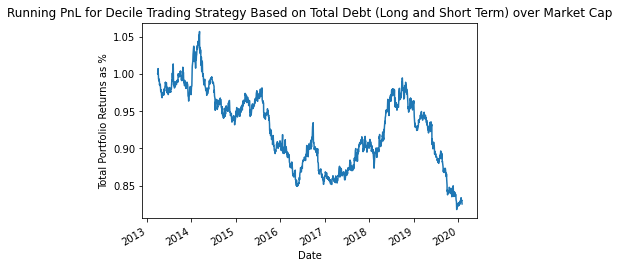

In [650]:
cum_prod['running_PnL'].plot()
plt.title('Running PnL for Decile Trading Strategy Based on Total Debt (Long and Short Term) over Market Cap')
plt.xlabel('Date')
plt.ylabel('Total Portfolio Returns as %');

# Step Four: Discussion of Results

We can clearly see above that our strategy was not very good, not only did we have very poor returns over the period, but we experienced a great deal of vol. We can compare this to the VIX and SPY for reference.


In [657]:
SPY = quandl.get('EOD/SPY', column_index = 11, start_date = '2013-01-01', end_date = '2020-01-01')
SPY_returns = ((SPY - SPY.iloc[0]) / SPY.iloc[0]) + 1
VIX = pd.read_csv('http://cache.quantconnect.com/alternative/cboe/vix.csv', header=1)
VIX.set_index('Date', inplace=True)
VIX = VIX.loc['1/2/2013':'01/02/2020']['VIX Close'];

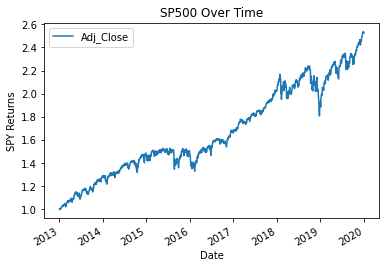

In [661]:
SPY_returns.plot()
plt.title('SP500 Over Time')
plt.ylabel('SPY Returns')
plt.xlabel('Date');

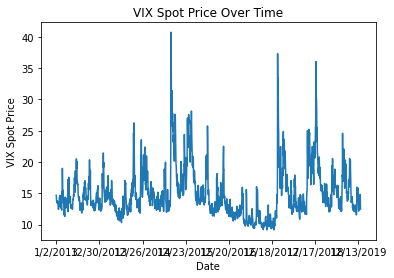

In [660]:
VIX.plot()
plt.title('VIX Spot Price Over Time')
plt.ylabel('VIX Spot Price')
plt.xlabel('Date');

In [646]:
df_to_scatter = pd.DataFrame()
df_to_scatter['my_returns'] = cum_prod['daily_PnL']
df_to_scatter['spy_returns'] = SPY['Adj_Close'].pct_change(1)
df_to_scatter.dropna(axis = 1, how='any');

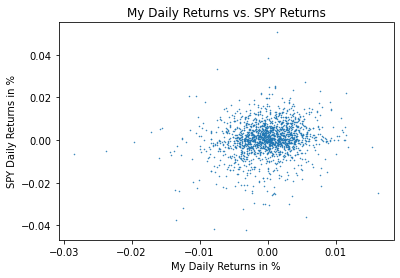

In [645]:
plt.scatter(df_to_scatter['my_returns'],df_to_scatter['spy_returns'], s = 0.25)
plt.title('My Daily Returns vs. SPY Returns')
plt.xlabel('My Daily Returns in %')
plt.ylabel('SPY Daily Returns in %');

In [649]:
beta = df_to_scatter['my_returns'].corr(df_to_scatter['spy_returns'])
print('The correlation between my daily returns and the SPY daily returns is: ', beta)

The correlation between my daily returns and the SPY daily returns is:  0.16415017334920853


From this, it appears that the strategies returns are correlated to the SPY, but are much, much lower than it at only 0.16. This would be a good sign if our performance wasn't so bad! It seems possible that my economic intuition at the start was wrong. I claimed that companies with low debt to market cap ratios would perform better than those with high debt to market cap ratios. At the time, I believed that lower debt to market cap ratios would imply that a company had a healither balance sheet and could be anticipated to grow more quickly. 

It is also important to note, that just trading the opposite hypothesis, would give a very similar result (the only difference would be the borrowing costs for the short positions). As such, we would get that the returns were much less with this strategy than just the regular SP500. This might be because companies that have more debt are using it to help grow faster and financing with debt is typically cheaper than financing with equity. However, at certain levels, being overleveraged might do more harm than good. It all depends on what the debt is going to, how productive it is, and whether or not the market thinks that this level of debt is appropriate. Given all of these factors, it is difficult, if not impossible, to design a good strategy around just this parameter. 

If you wanted to try other ratios, all you would have to do is just change the variable names above. I have already loaded the data, and the algorithm design would be exactly the same given that the incoming data would have the same format. 